In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport
from scipy import stats
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Data Preparation and Evaluation

In [138]:
# Removing the 'major' and 'region' columns from the dataset.
# These columns can introduce bias and limit the model to only the provided options,
# as we are not given all possible majors and regions. This incomplete representation
# may result in a model that doesn't generalize well to the full student population.

# Load your real dataset
student_data = pd.DataFrame({
    'age': [20, 21, 19, 22, 20],
    'gender': ['Male', 'Female', 'Female', 'Female', 'Male'],
    'year': [3, 2, 1, 4, 2],
    'logins_per_week': [5, 3, 7, 2, 6],
    'videos_watched': [12, 8, 15, 5, 10],
    'time_spent_on_platform': [8, 4, 12, 3, 9],
    'avg_quiz_score': [85, 70, 90, 65, 80],
    'courses_completed': [3, 1, 4, 2, 3],
    'course_started': [5,4,6,5,5],
    'avg_score_across_courses': [80, 65, 88, 72, 78]
})

In [139]:
!pip install pandas matplotlib seaborn plotly ydata-profiling

**EDA for the Student_data**

student Data:
   age  gender  year  logins_per_week  videos_watched  time_spent_on_platform  \
0   20    Male     3                5              12                       8   
1   21  Female     2                3               8                       4   
2   19  Female     1                7              15                      12   
3   22  Female     4                2               5                       3   
4   20    Male     2                6              10                       9   

   avg_quiz_score  courses_completed  course_started  avg_score_across_courses  
0              85                  3               5                        80  
1              70                  1               4                        65  
2              90                  4               6                        88  
3              65                  2               5                        72  
4              80                  3               5                        78  

Descriptive 

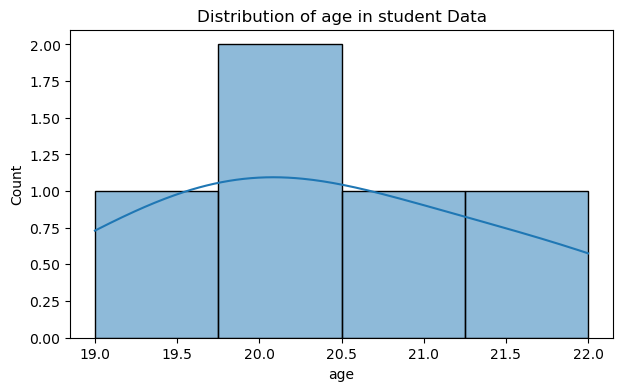

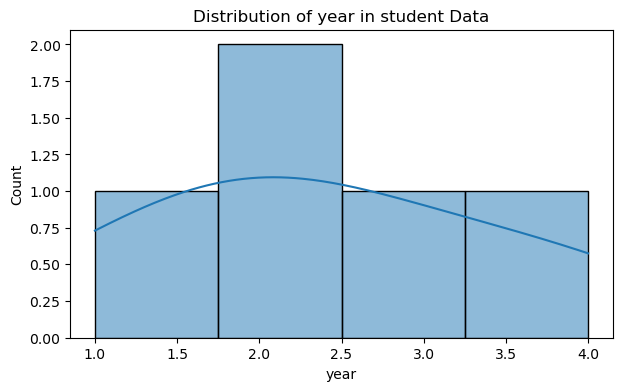

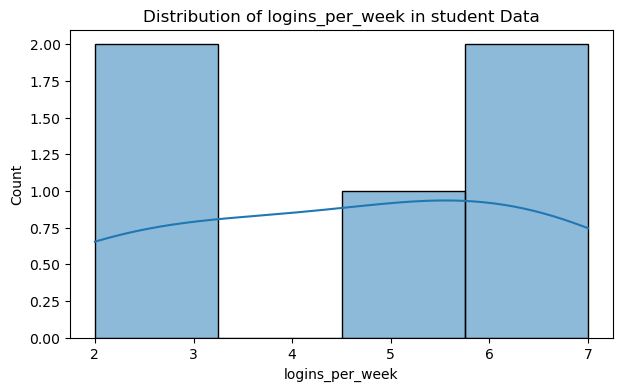

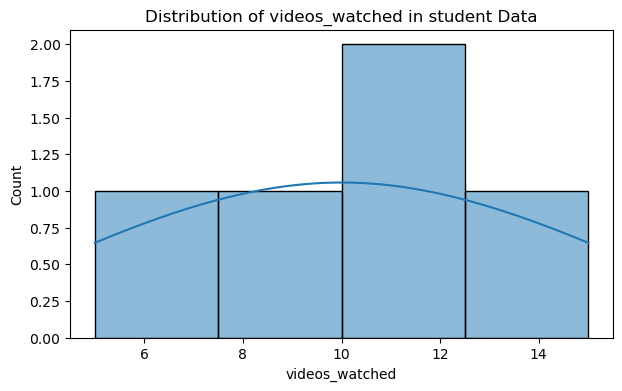

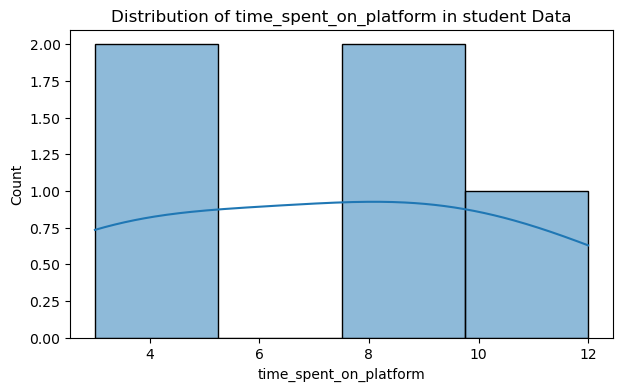

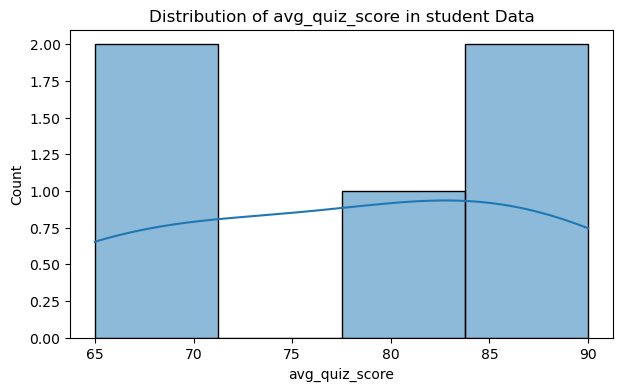

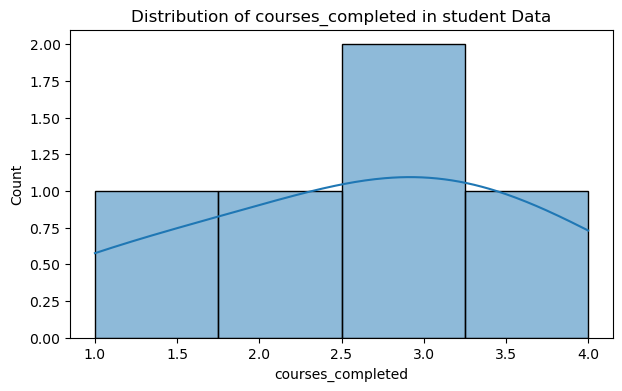

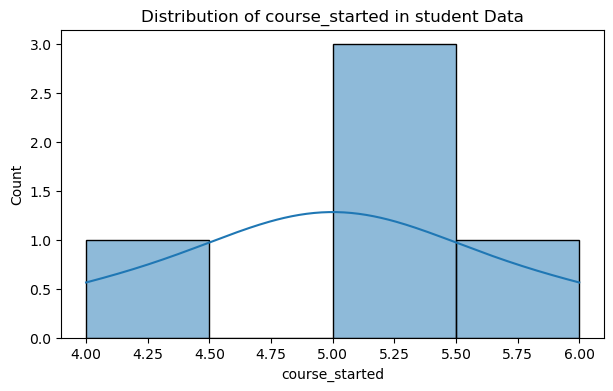

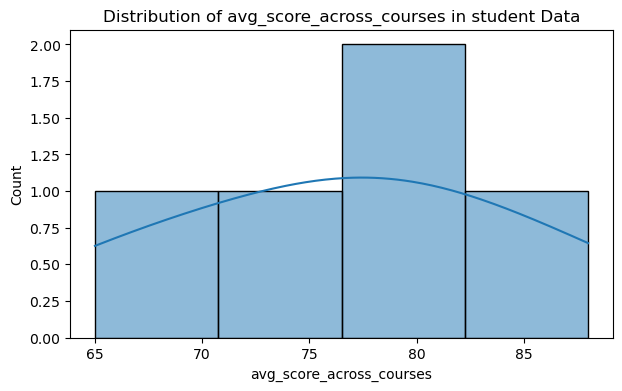

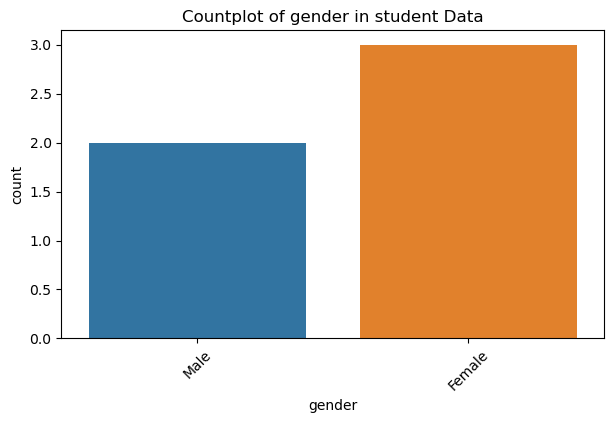

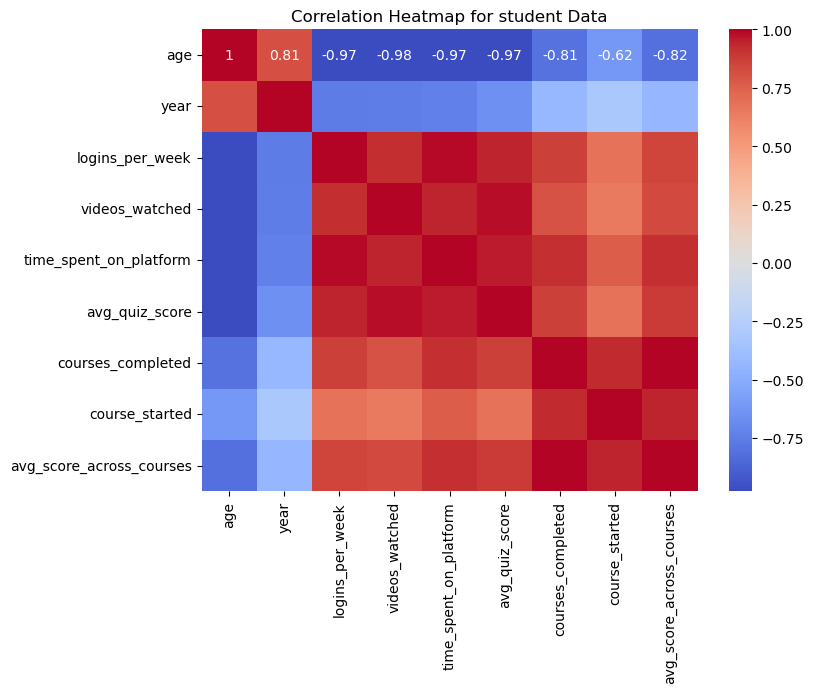


Generating EDA Report for student Data...



Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Visualization: Logins per Week vs Average Quiz Score


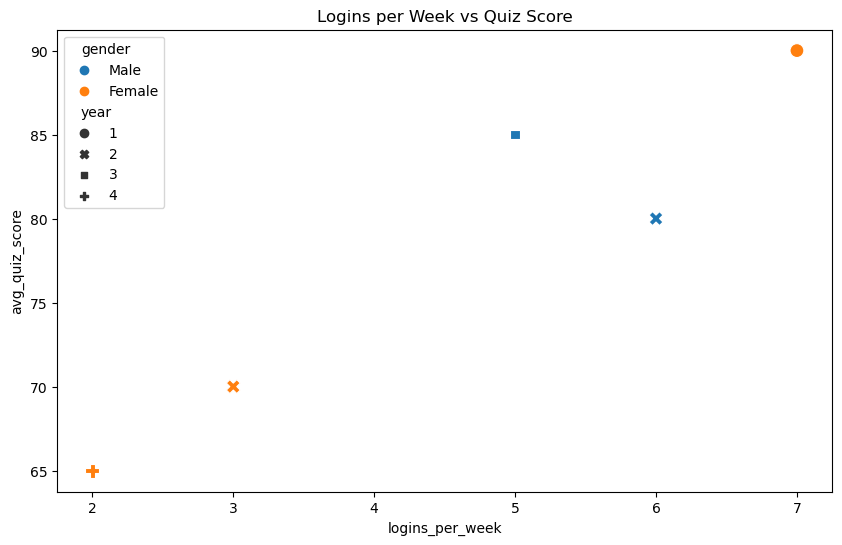


Visualization: Courses Completed vs Average Quiz Score


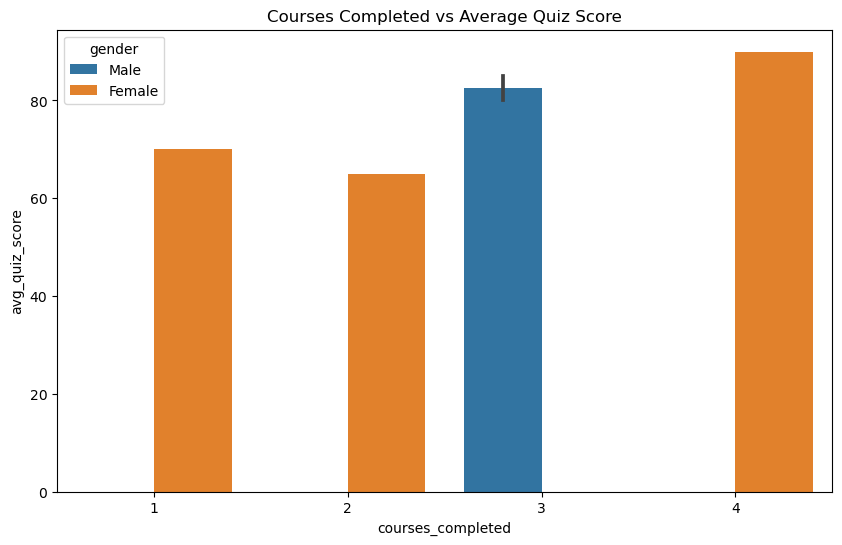

In [140]:

# Function to generate descriptive statistics
def descriptive_statistics(df, name):
    print(f"Descriptive Statistics for {name}:")
    print(df.describe(include='all'))
    print("\n" + "="*50)

# Function for visualizing the distributions of numeric and categorical features
def visualize_data(df, name):
    print(f"\nVisualizations for {name}:")

    # Histogram for numeric columns
    numeric_columns = df.select_dtypes(include=[float, int]).columns
    for col in numeric_columns:
        plt.figure(figsize=(7, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col} in {name}")
        plt.show()

    # Countplot for categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        plt.figure(figsize=(7, 4))
        sns.countplot(x=col, data=df)
        plt.title(f"Countplot of {col} in {name}")
        plt.xticks(rotation=45)
        plt.show()

# Function for creating correlation heatmaps
def correlation_heatmap(df, name):
    numeric_columns = df.select_dtypes(include=[float, int]).columns
    if len(numeric_columns) > 1:
        plt.figure(figsize=(8, 6))
        sns.heatmap(df[numeric_columns].corr(), annot=True, cmap="coolwarm")
        plt.title(f"Correlation Heatmap for {name}")
        plt.show()

# Generating EDA report using pandas_profiling
def generate_eda_report(df, name):
    print(f"\nGenerating EDA Report for {name}...\n")
    profile = ProfileReport(df, title=f"EDA Report for {name}")
    profile.to_notebook_iframe()

def statistics():
    #combined_data = combine_dataframes()
    name = "student Data"

    # Display first few rows of the combined dataframe
    print("student Data:")
    print(student_data.head())
    print("\n" + "="*50)

    # Descriptive Statistics
    print("Descriptive Statistics of student Data:")
    print(student_data.describe())
    print("\n" + "="*50)

    descriptive_statistics(student_data, name)
    visualize_data(student_data, name)
    correlation_heatmap(student_data, name)
    generate_eda_report(student_data, name)


    # Visualizations
    print("Visualization: Logins per Week vs Average Quiz Score")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=student_data['logins_per_week'], y=student_data['avg_quiz_score'], hue=student_data['gender'], style=student_data['year'], s=100)
    plt.title("Logins per Week vs Quiz Score")
    plt.show()

    print("\nVisualization: Courses Completed vs Average Quiz Score")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=student_data['courses_completed'], y=student_data['avg_quiz_score'], hue=student_data['gender'])
    plt.title("Courses Completed vs Average Quiz Score")
    plt.show()

# Function to perform EDA on all datasets
def perform_eda():
        statistics()

# Perform EDA 
perform_eda()


In [141]:
!pip install sdv

**Generating and evaluating synthetic data using the CTGAN**

The process is divided into several key functions:<br>

Define Metadata: A function to create metadata from the input student_data to help the CTGAN model understand the structure of the dataset.<br>

Generate Synthetic Data: This function initializes the CTGAN model and trains it using the input data (student_data). The model then generates synthetic data, with some post-processing to remove irrelevant columns and invalid rows.<br>

Evaluate Synthetic Data: The function compares the synthetic data against the original data using descriptive statistics, error metrics (MSE, R²), and visualizations such as KDE plots.<br>

Correlation Matrix: This function plots the correlation matrix of the numerical features for both original and synthetic data, helping to compare the relationships between features.<br>

Compare Distributions: This function provides an in-depth comparison between the distributions of the original and synthetic datasets. It visualizes the distributions with histograms, box plots, and performs a **hypothesis test (Kolmogorov-Smirnov test)** to check if the distributions of the two datasets are statistically similar.<br>

In [142]:
random_state = 13

In [143]:
def define_metadata(data):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data)
    return metadata

# Generate synthetic data using CTGAN
def generate_synthetic_data(student_data, n_samples=128):
    # Initialize CTGAN
    metadata = define_metadata(student_data)
    
    model = CTGANSynthesizer(
        metadata,
        epochs=1000,  
        generator_dim=(256, 128),  # Adjust generator dimensions
        discriminator_dim=(256, 128)  # Adjust discriminator dimensions
    )
    # Fit the model on the student data
    model.fit(student_data)

    # Generate synthetic data
    synthetic_data = model.sample(n_samples)
    
    return synthetic_data

In [144]:
# Evaluate the synthetic data against the original data
def evaluate_synthetic_data(original_data, synthetic_data):
    # Display descriptive statistics
    print("Descriptive Statistics of Original Data:")
    print(original_data.describe())

    print("\nDescriptive Statistics of Synthetic Data:")
    print(synthetic_data.describe())

    # Compare specific columns
    for col in original_data.select_dtypes(include=[np.number]).columns:
        if col in synthetic_data.columns:
            mse = mean_squared_error(original_data[col], synthetic_data[col])
            r2 = r2_score(original_data[col], synthetic_data[col])
            print(f"\nColumn: {col}\nMean Squared Error: {mse:.2f}, R^2 Score: {r2:.2f}")

    # Visual comparison
    for col in original_data.select_dtypes(include=[np.number]).columns:
        if col in synthetic_data.columns:
            plt.figure(figsize=(10, 5))
            sns.kdeplot(original_data[col], label='Original', fill=True)
            sns.kdeplot(synthetic_data[col], label='Synthetic', fill=True)
            plt.title(f'Distribution Comparison for {col}')
            plt.legend()
            plt.show()

In [145]:
# Function to plot correlation matrix
def plot_correlation_matrix(data, title):
    numeric_columns = data.select_dtypes(include=[float, int]).columns
    if len(numeric_columns) > 1:
        plt.figure(figsize=(8, 6))
        sns.heatmap(data[numeric_columns].corr(), annot=True, cmap="coolwarm")
        plt.title(f"Correlation Heatmap for {title}")
        plt.show()

In [146]:
def compare_distributions(original_data, synthetic_data):
    # 1. Descriptive Statistics
    print("Original Data Descriptive Statistics:")
    print(original_data.describe())

    print("\nSynthetic Data Descriptive Statistics:")
    print(synthetic_data.describe())

    # 2. Visualizations
    numeric_columns = original_data.select_dtypes(include=[float, int]).columns

    # Histograms
    for col in numeric_columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(original_data[col], color='blue', label='Original', kde=True, stat='density', bins=15)
        sns.histplot(synthetic_data[col], color='orange', label='Synthetic', kde=True, stat='density', bins=15)
        plt.title(f"Histogram of {col} - Original vs Synthetic")
        plt.legend()
        plt.show()

    # Boxplots
    for col in numeric_columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=[original_data[col], synthetic_data[col]], palette=['blue', 'orange'])
        plt.xticks([0, 1], ['Original', 'Synthetic'])
        plt.title(f"Boxplot of {col} - Original vs Synthetic")
        plt.show()

    # 3. Hypothesis Testing
    print("\nHypothesis Testing Results (Kolmogorov-Smirnov Test):")
    for col in numeric_columns:
        ks_statistic, p_value = stats.ks_2samp(original_data[col], synthetic_data[col])
        print(f"{col}: KS Statistic = {ks_statistic:.4f}, p-value = {p_value:.4f}")
        if p_value < 0.05:
            print(f"Result: Reject the null hypothesis - distributions are different.")
        else:
            print(f"Result: Fail to reject the null hypothesis - distributions are similar.")

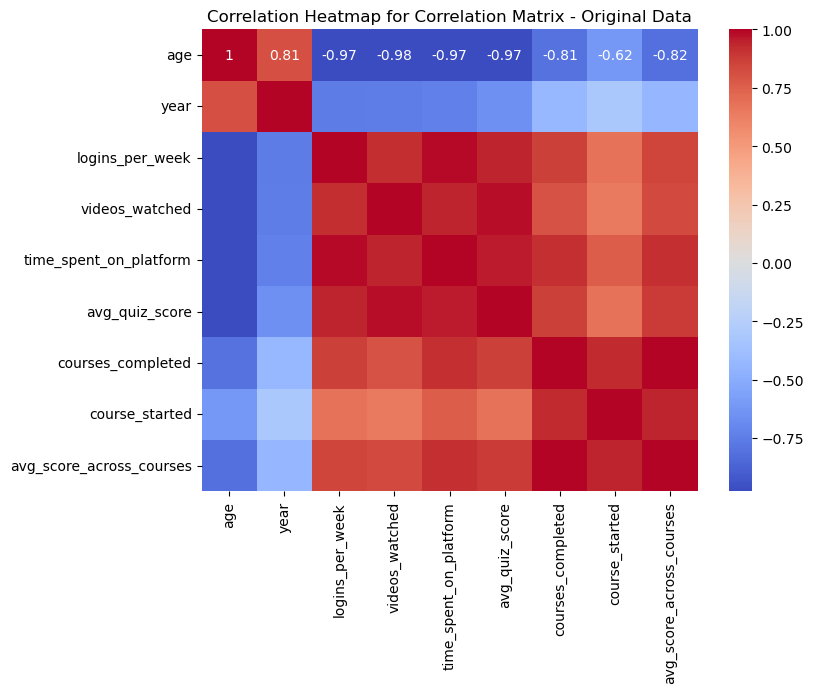

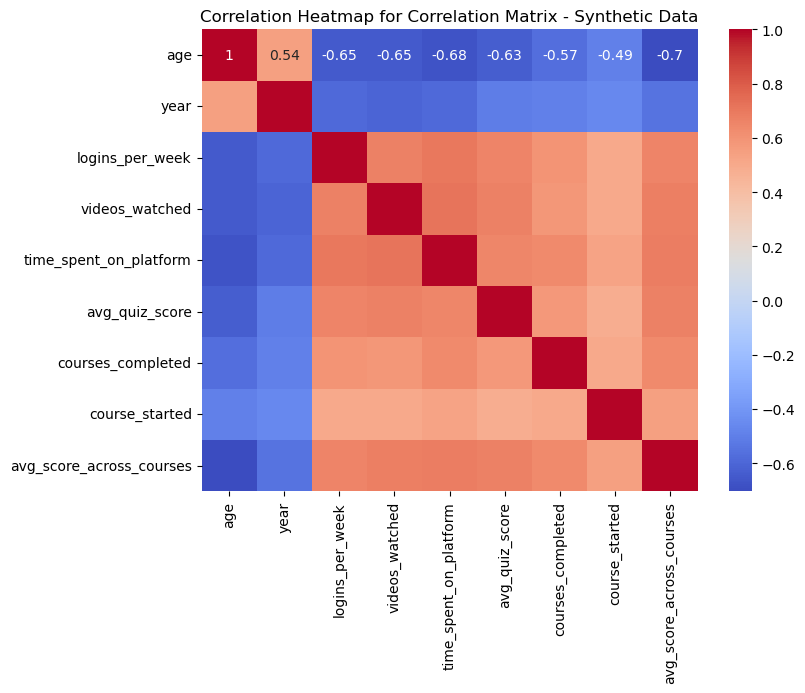

Original Data Descriptive Statistics:
             age      year  logins_per_week  videos_watched  \
count   5.000000  5.000000         5.000000        5.000000   
mean   20.400000  2.400000         4.600000       10.000000   
std     1.140175  1.140175         2.073644        3.807887   
min    19.000000  1.000000         2.000000        5.000000   
25%    20.000000  2.000000         3.000000        8.000000   
50%    20.000000  2.000000         5.000000       10.000000   
75%    21.000000  3.000000         6.000000       12.000000   
max    22.000000  4.000000         7.000000       15.000000   

       time_spent_on_platform  avg_quiz_score  courses_completed  \
count                5.000000        5.000000           5.000000   
mean                 7.200000       78.000000           2.600000   
std                  3.701351       10.368221           1.140175   
min                  3.000000       65.000000           1.000000   
25%                  4.000000       70.000000         

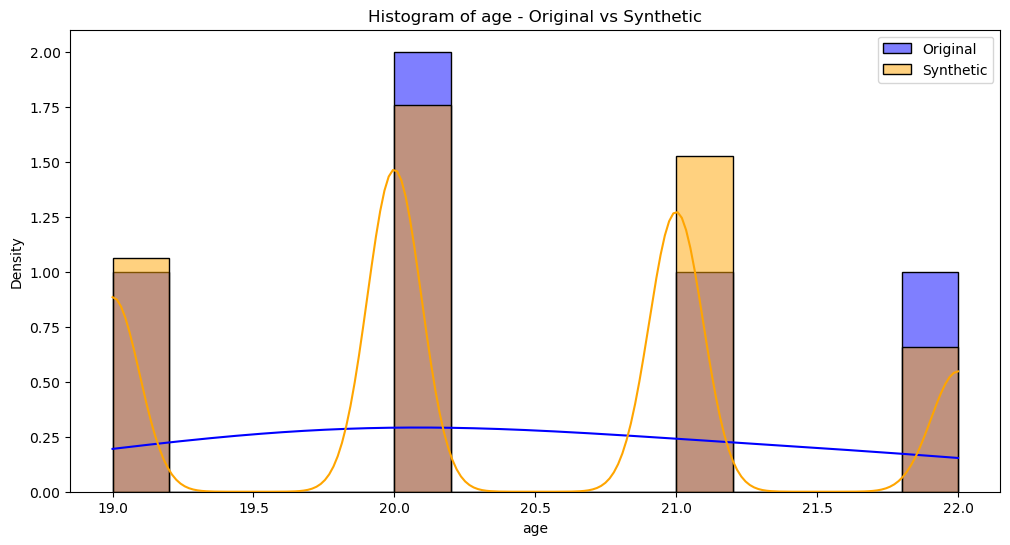

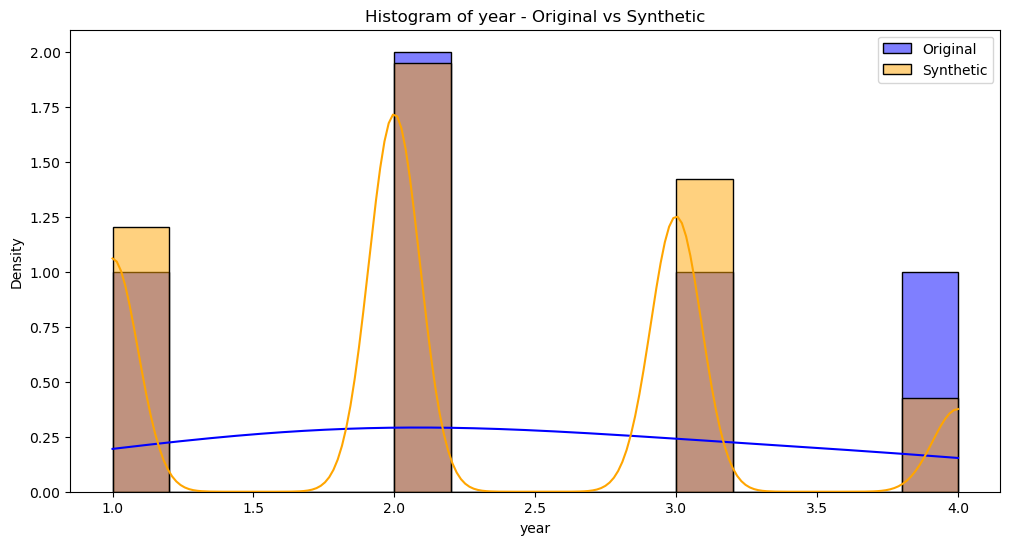

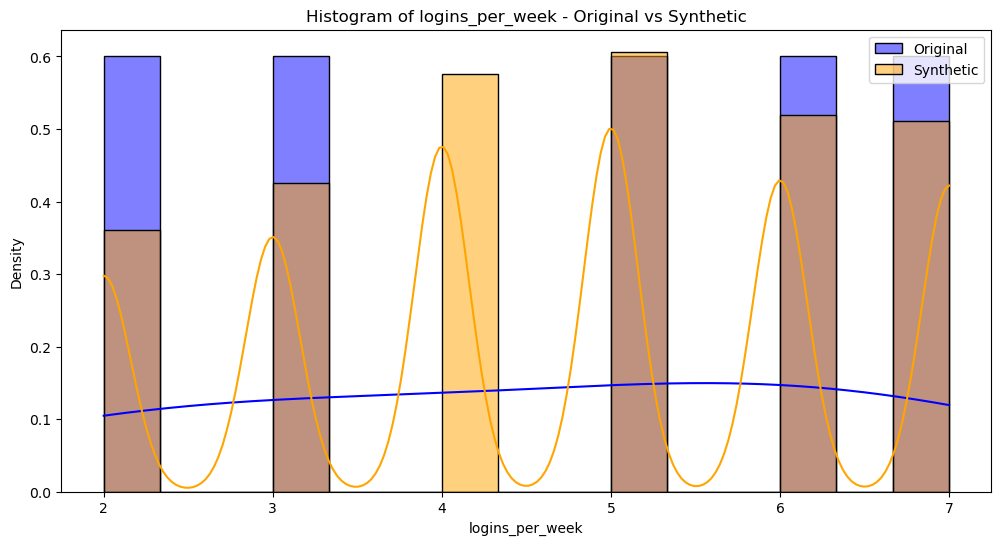

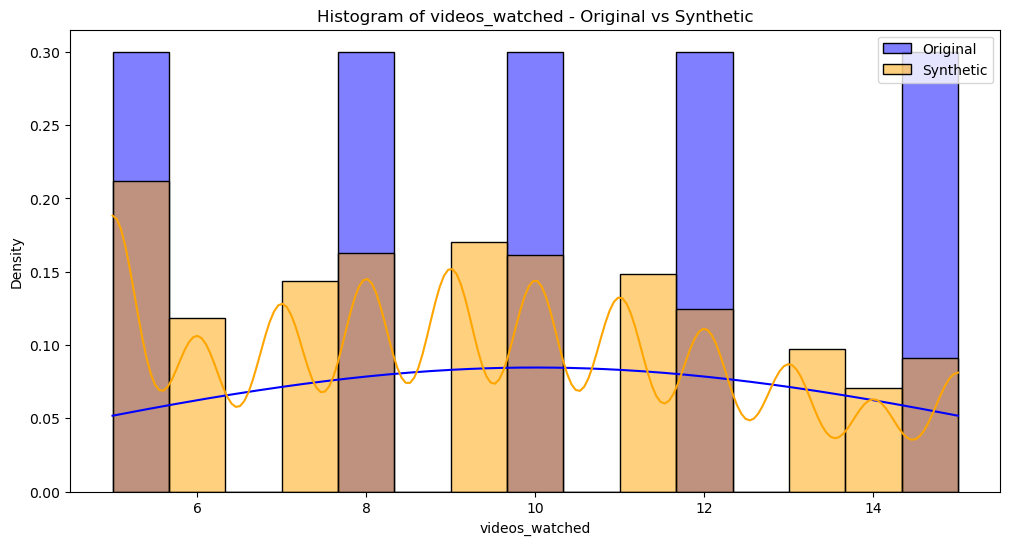

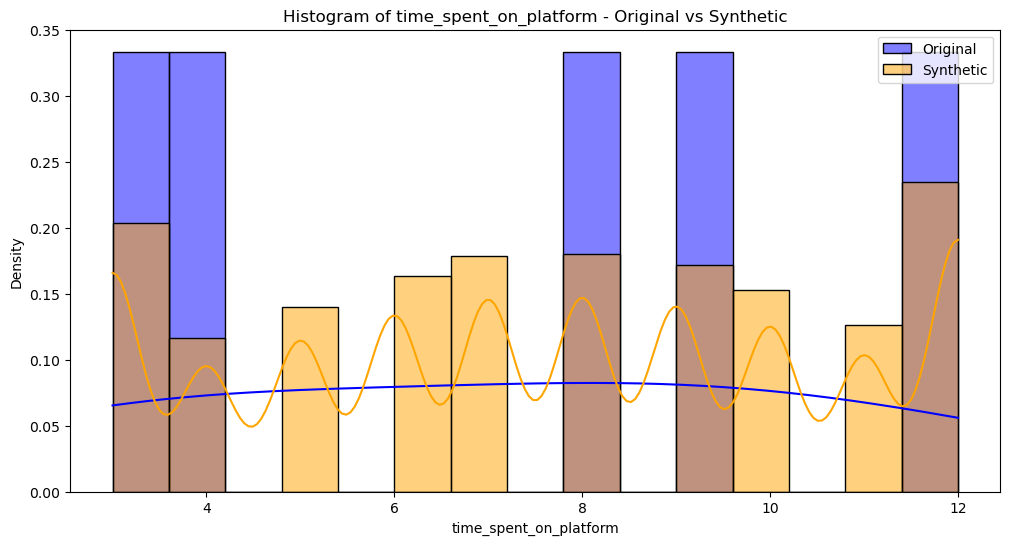

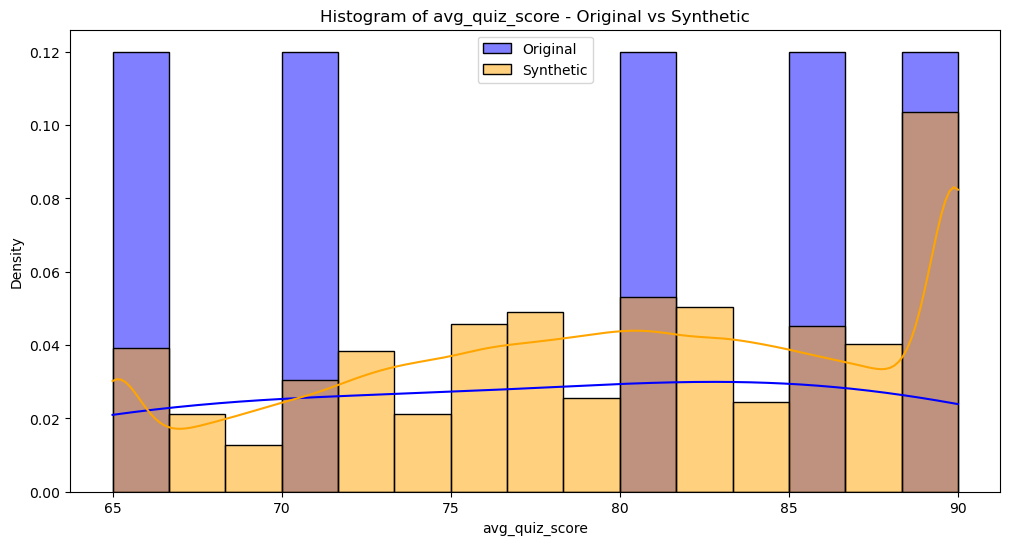

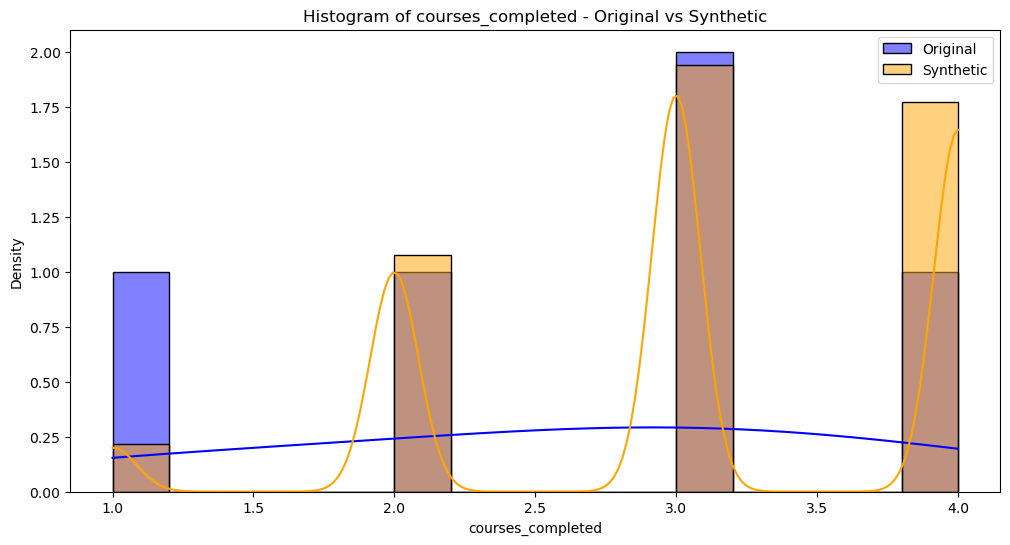

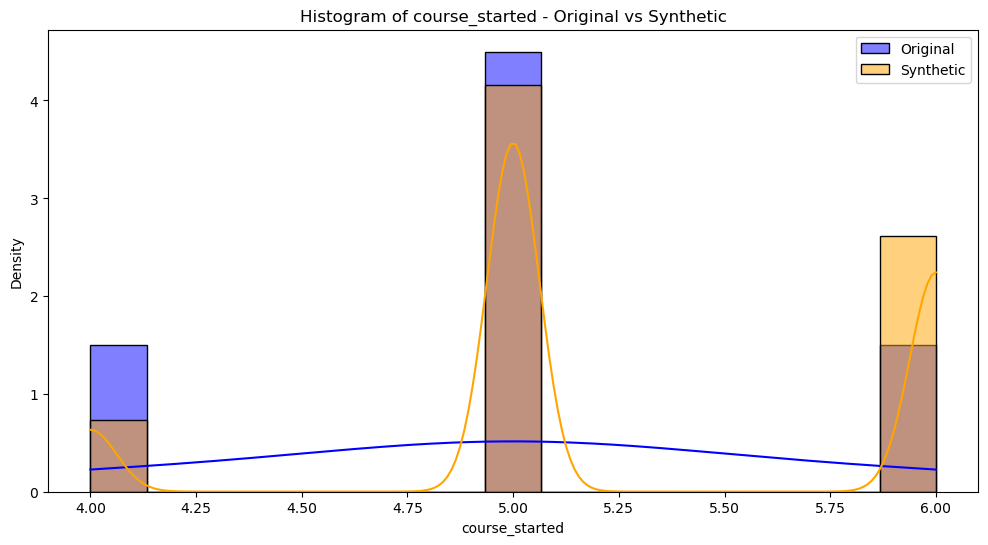

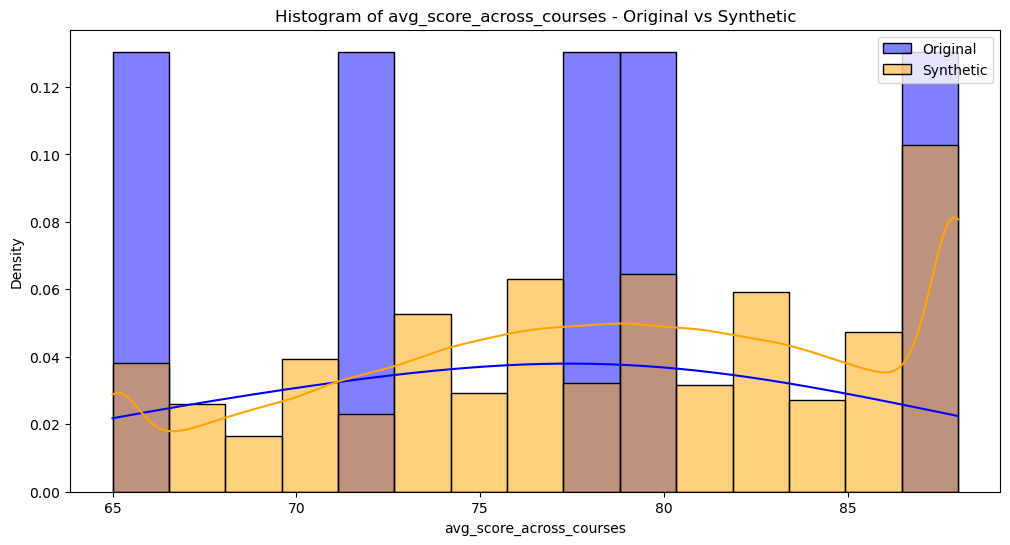

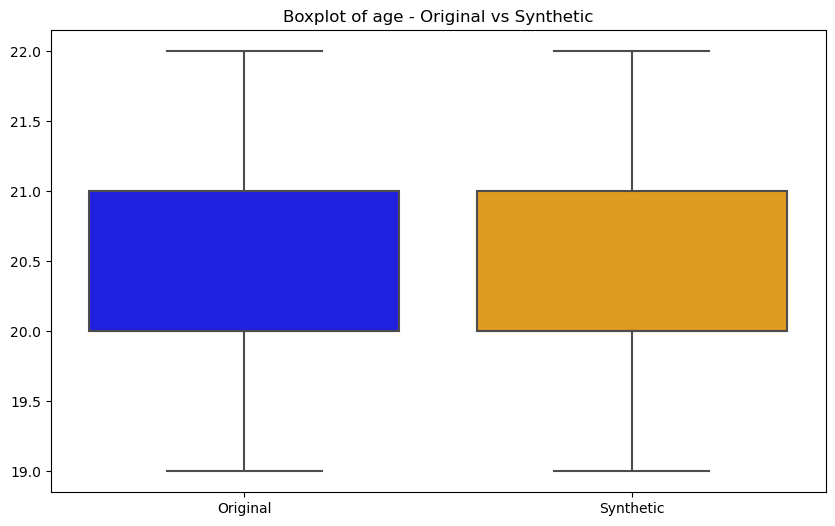

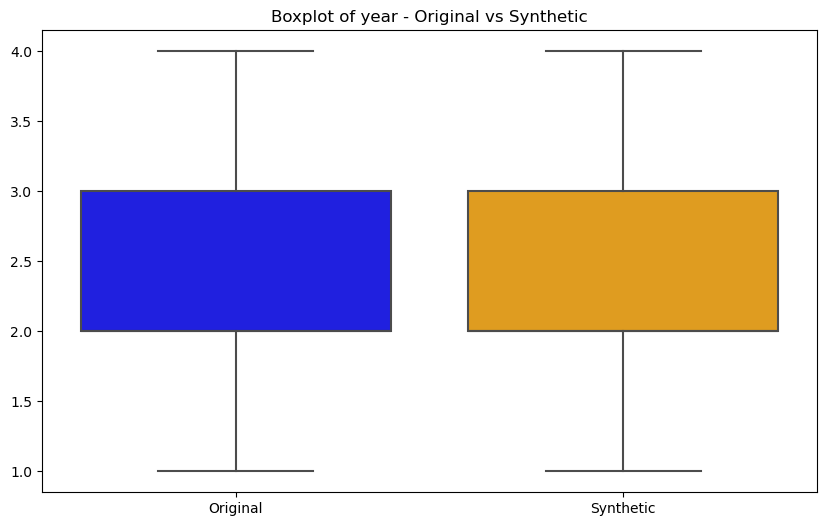

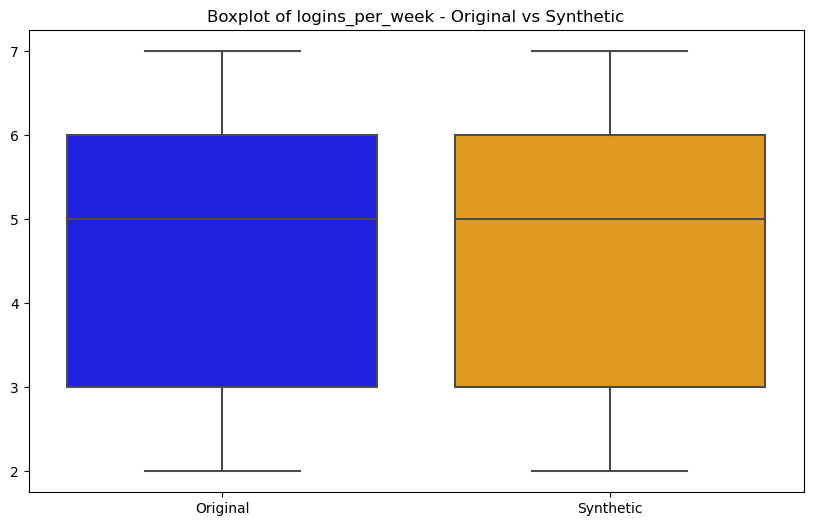

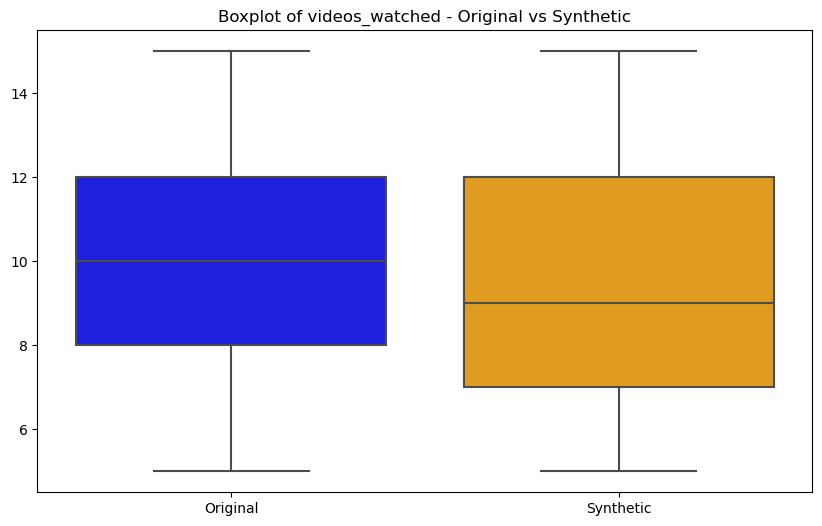

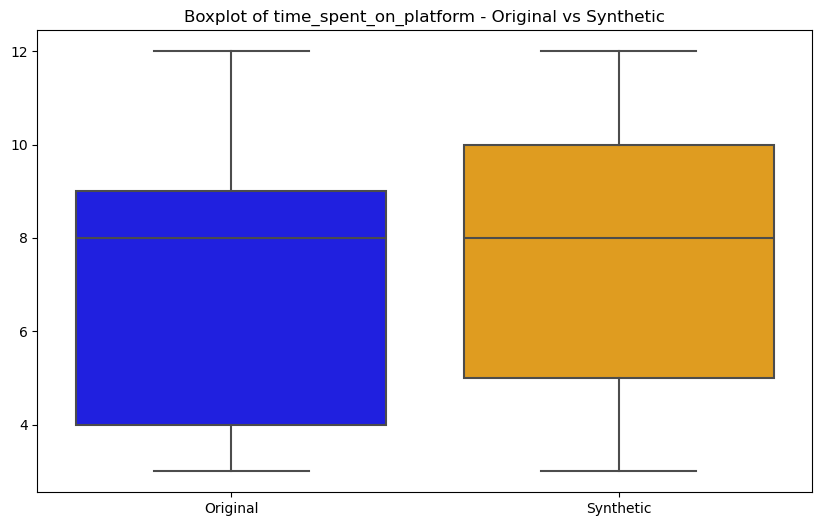

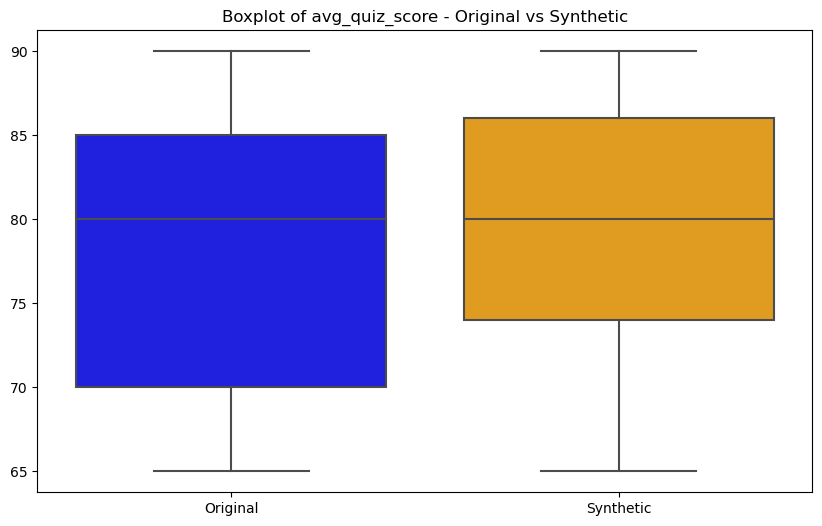

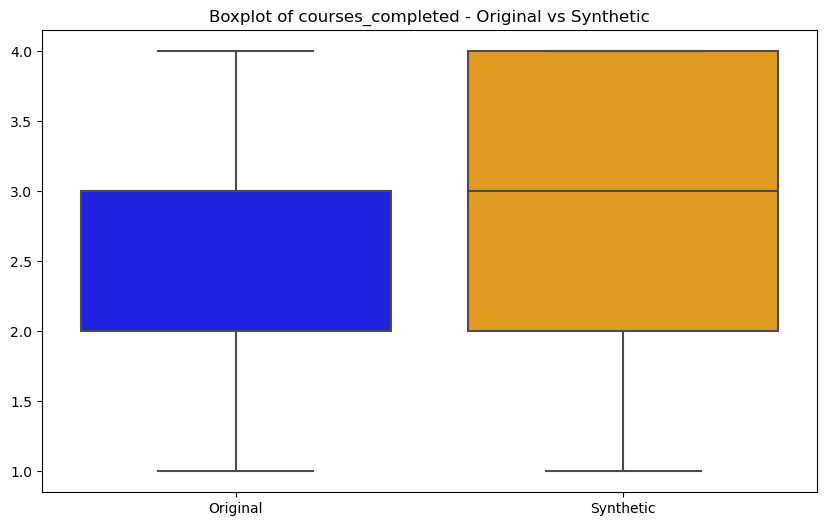

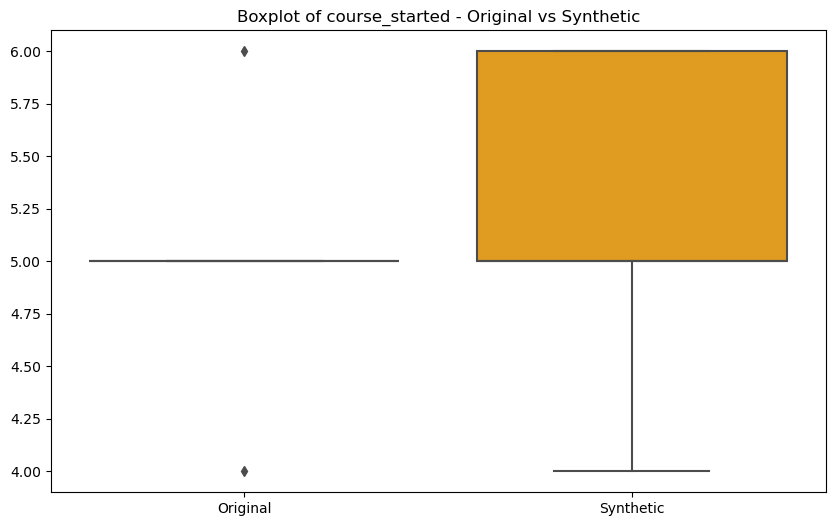

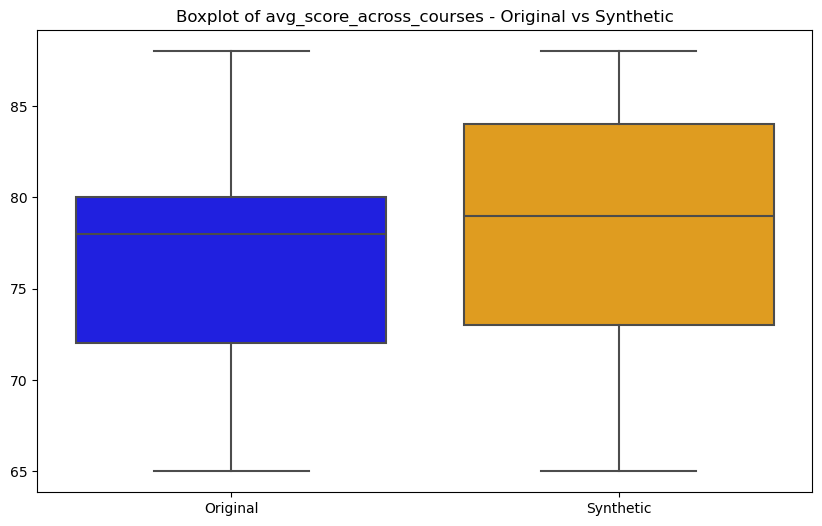


Hypothesis Testing Results (Kolmogorov-Smirnov Test):
age: KS Statistic = 0.0688, p-value = 1.0000
Result: Fail to reject the null hypothesis - distributions are similar.
year: KS Statistic = 0.1147, p-value = 1.0000
Result: Fail to reject the null hypothesis - distributions are similar.
logins_per_week: KS Statistic = 0.1380, p-value = 0.9997
Result: Fail to reject the null hypothesis - distributions are similar.
videos_watched: KS Statistic = 0.1444, p-value = 0.9993
Result: Fail to reject the null hypothesis - distributions are similar.
time_spent_on_platform: KS Statistic = 0.2081, p-value = 0.9481
Result: Fail to reject the null hypothesis - distributions are similar.
avg_quiz_score: KS Statistic = 0.2537, p-value = 0.8330
Result: Fail to reject the null hypothesis - distributions are similar.
courses_completed: KS Statistic = 0.1570, p-value = 0.9977
Result: Fail to reject the null hypothesis - distributions are similar.
course_started: KS Statistic = 0.1480, p-value = 0.9990
Re

In [147]:
# Generate synthetic data
n_samples = 100000
synthetic_data = generate_synthetic_data(student_data, n_samples)

# Plot correlation matrices for both datasets
plot_correlation_matrix(student_data, title="Correlation Matrix - Original Data")
plot_correlation_matrix(synthetic_data, title="Correlation Matrix - Synthetic Data")

# Evaluate synthetic data
compare_distributions(student_data, synthetic_data)

In [148]:
synthetic_data.shape

(100000, 10)

In [149]:
synthetic_data.describe()

,age,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,courses_completed,course_started,avg_score_across_courses
count,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000
mean,20.355480,2.2140,4.677470,9.311240,7.631310,79.627680,3.053320,5.24987,78.34813
std,0.957049,0.9057,1.609885,3.002749,2.948397,7.598431,0.859095,0.61945,6.77898
min,19.000000,1.0000,2.000000,5.000000,3.000000,65.000000,1.000000,4.00000,65.00000
25%,20.000000,2.0000,3.000000,7.000000,5.000000,74.000000,2.000000,5.00000,73.00000
50%,20.000000,2.0000,5.000000,9.000000,8.000000,80.000000,3.000000,5.00000,79.00000
75%,21.000000,3.0000,6.000000,12.000000,10.000000,86.000000,4.000000,6.00000,84.00000
max,22.000000,4.0000,7.000000,15.000000,12.000000,90.000000,4.000000,6.00000,88.00000


In [150]:
synthetic_data.head()

,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,courses_completed,course_started,avg_score_across_courses
0,20,Female,2,5,7,5,70,3,5,82
1,20,Male,2,7,6,6,90,4,5,83
2,20,Female,2,3,9,3,76,2,5,72
3,20,Male,2,5,9,8,87,4,5,78
4,19,Female,2,6,8,7,86,3,6,81


In [151]:
synthetic_data['gender'] = synthetic_data['gender'].map({'Male': 1, 'Female': 0})

In [152]:
data = synthetic_data.copy()

In [153]:
synthetic_data.head()

,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,courses_completed,course_started,avg_score_across_courses
0,20,0,2,5,7,5,70,3,5,82
1,20,1,2,7,6,6,90,4,5,83
2,20,0,2,3,9,3,76,2,5,72
3,20,1,2,5,9,8,87,4,5,78
4,19,0,2,6,8,7,86,3,6,81


In [154]:
data.head()

,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,courses_completed,course_started,avg_score_across_courses
0,20,0,2,5,7,5,70,3,5,82
1,20,1,2,7,6,6,90,4,5,83
2,20,0,2,3,9,3,76,2,5,72
3,20,1,2,5,9,8,87,4,5,78
4,19,0,2,6,8,7,86,3,6,81


In [155]:
# Calculate course completion ratio
data['course_completion_ratio'] = data['courses_completed'] / data['course_started']

# Handle potential division by zero (if any student has not started any course)
data['course_completion_ratio'].fillna(0, inplace=True)
data['completion_status'] = np.where(data['course_completion_ratio'] >= 0.5, 1, 0)
# Drop any unnecessary columns, like 'courses_completed' and 'course_started', if needed
data.drop(columns=['courses_completed', 'course_started'], inplace=True)

# Check the updated dataset
data.head()


,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,avg_score_across_courses,course_completion_ratio,completion_status
0,20,0,2,5,7,5,70,82,0.6,1
1,20,1,2,7,6,6,90,83,0.8,1
2,20,0,2,3,9,3,76,72,0.4,0
3,20,1,2,5,9,8,87,78,0.8,1
4,19,0,2,6,8,7,86,81,0.5,1


In [156]:
data.shape

(100000, 10)

In [157]:
data.head()

,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,avg_score_across_courses,course_completion_ratio,completion_status
0,20,0,2,5,7,5,70,82,0.6,1
1,20,1,2,7,6,6,90,83,0.8,1
2,20,0,2,3,9,3,76,72,0.4,0
3,20,1,2,5,9,8,87,78,0.8,1
4,19,0,2,6,8,7,86,81,0.5,1


# Clustering Analysis

In [158]:
# Select relevant features (drop 'course_completion_ratio')
X = data.drop(columns=['course_completion_ratio'])

# Preprocess the data
numeric_features = ['age', 'logins_per_week', 'videos_watched', 'time_spent_on_platform', 'avg_quiz_score', 'avg_score_across_courses']
categorical_features = ['gender', 'year']

# Standardize the numeric features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])

# Convert categorical features using one-hot encoding
X_scaled = pd.get_dummies(X_scaled, columns=categorical_features, drop_first=True)


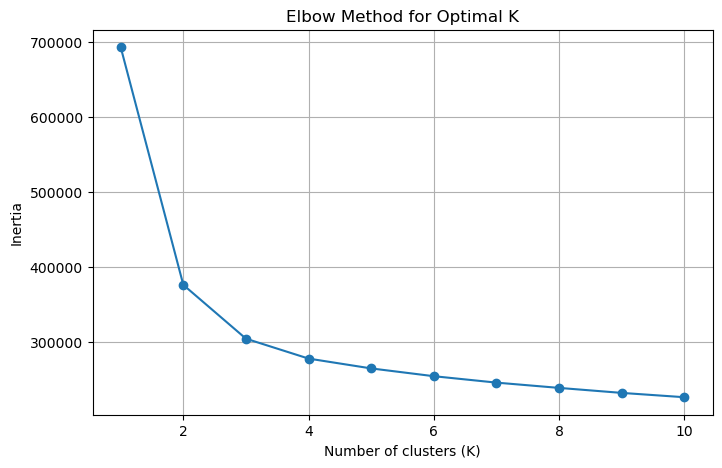

In [159]:
# Determine the optimal number of clusters using the Elbow method
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state) 
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)  # Optional: add grid for better readability
plt.show()

In [160]:
# Fit K-Means with the chosen number of clusters 
kmeans = KMeans(n_clusters=4, random_state=random_state)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataset
X_scaled['cluster'] = kmeans.labels_


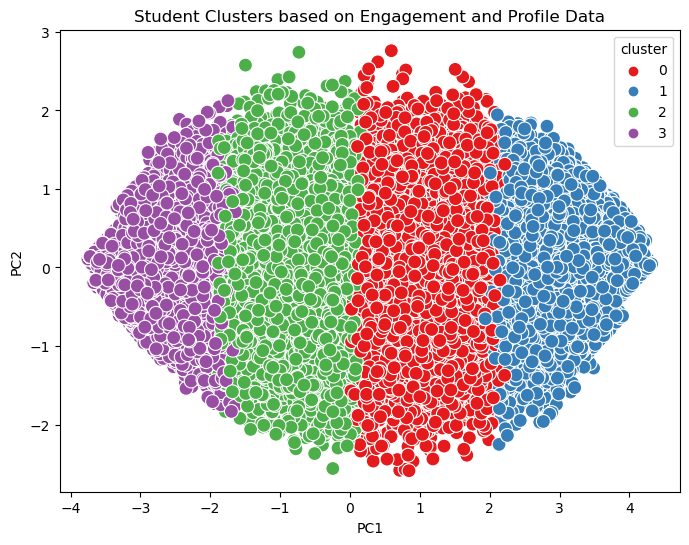

In [161]:
# Reduce the data to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled.drop(columns=['cluster']))

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = X_scaled['cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set1', s=100)
plt.title('Student Clusters based on Engagement and Profile Data')
plt.show()


In [162]:
# Analyze the average course completion ratio for each cluster
cluster_analysis = data.groupby('cluster')['course_completion_ratio'].mean()
print(cluster_analysis)

# Count the number of students in each cluster
cluster_counts = data['cluster'].value_counts()
print(cluster_counts)


cluster
0    0.553563
1    0.446067
2    0.625063
3    0.665183
Name: course_completion_ratio, dtype: float64
cluster
2    29409
0    27749
3    23382
1    19460
Name: count, dtype: int64


In [163]:
# Analyze the average course completion ratio for each cluster
cluster_risk = data.groupby('cluster')['course_completion_ratio'].mean().sort_values()

# Display the clusters sorted by risk (lower completion ratio = higher risk)
print("Cluster Risk Analysis (Lower completion ratio indicates higher risk):")
print(cluster_risk)


Cluster Risk Analysis (Lower completion ratio indicates higher risk):
cluster
1    0.446067
0    0.553563
2    0.625063
3    0.665183
Name: course_completion_ratio, dtype: float64


In [164]:
# Get average feature values for each cluster
cluster_analysis = data.groupby('cluster').mean()

# Display the analysis for high-risk clusters
print("Cluster Analysis (Average Feature Values):")
(cluster_analysis)


Cluster Analysis (Average Feature Values):


,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,avg_score_across_courses,course_completion_ratio,completion_status
cluster,,,,,,,,,,
0,20.730080,0.362824,2.490901,3.993585,7.867563,6.217593,76.819093,75.772893,0.553563,0.721323
1,21.537102,0.188695,3.117729,2.674974,5.843577,4.004419,69.987410,69.554728,0.446067,0.440236
2,20.048659,0.511476,1.985311,5.241219,10.073617,8.670713,82.364786,80.765378,0.625063,0.923969
3,19.313403,0.663502,1.420879,6.446626,12.951672,11.020272,87.541442,85.682448,0.665183,0.989051


# Insights from clustering



---

**Cluster 0 (Moderate-Risk Cluster)**

Completion Ratio: 0.55 (moderate risk).<br>
Demographics: Students around 20.73 years, about 36% female.<br>
Engagement:<br>
Logins per week: 3.99 (moderate).<br>
Videos watched: 7.87 (moderate).<br>
Time spent on platform: 6.22 hours (moderate).<br>
Performance:<br>
Average quiz score: 76.82 (moderate-high).<br>
Average course score: 75.77 (moderate-high).<br>
Completion Status: 72.13% complete their courses.<br>

---

**Cluster 1 (High-Risk Cluster)**

Completion Ratio: 0.44 (high risk).<br>
Demographics: Older students (average age 21.54), about 19% female.<br>
Engagement:<br>
Logins per week: 2.67 (low).<br>
Videos watched: 5.84 (low).<br>
Time spent on platform: 4.00 hours (low).<br>
Performance:<br>
Average quiz score: 69.99 (moderate).<br>
Average course score: 69.55 (moderate).<br>
Completion Status: 44.02% complete their courses.<br>

---

**Cluster 2 (Low-Risk Cluster)**

Completion Ratio: 0.63 (low risk).<br>
Demographics: Students around 20.05 years, about 51% female.<br>
Engagement:<br>
Logins per week: 5.24 (high).<br>
Videos watched: 10.07 (high).<br>
Time spent on platform: 8.67 hours (high).<br>
Performance:<br>
Average quiz score: 82.36 (high).<br>
Average course score: 80.77 (high).<br>
Completion Status: 92.40% complete their courses.<br>

---

**Cluster 3 (Lowest-Risk Cluster)**

Completion Ratio: 0.67 (lowest risk).<br>
Demographics: Youngest students (average age 19.31), about 66% female.<br>
Engagement:<br>
Logins per week: 6.45 (high).<br>
Videos watched: 12.95 (high).<br>
Time spent on platform: 11.02 hours (high).<br>
Performance:<br>
Average quiz score: 87.54 (highest).<br>
Average course score: 85.68 (highest).<br>
Completion Status: 98.91% complete their courses.<br>

---


Key Features Contributing to Risk:<br>
Logins per week: Lower logins correlate with higher risk (clusters 1 and 3 have low logins).<br>
Time spent on platform: Low time spent on the platform correlates with higher risk.<br>
Average quiz scores and course scores: Lower performance correlates with higher dropout rates.<br>
Gender: All-male clusters (1 and 3) have higher risk compared to mixed-gender clusters.<br>

-----------------------------------------------------------------------------------------------------------------------------

# Recommendations to Minimize Risk for High-Risk Clusters:

Increase Engagement (Logins and Time Spent):<br>
Encourage more frequent logins and platform interaction through notifications, personalized emails, or incentives for completing activities.<br>
Introduce time-based goals or reminders for students to log in and spend more time on the platform.<br>

Content Personalization:<br>
For clusters with lower video engagement, personalize course content based on their learning patterns to increase relevance and motivation.<br>

Support for Struggling Students:<br>
Offer additional support (e.g., mentoring, tutoring) for students in high-risk clusters (especially Cluster 1). Monitoring their progress early can help identify those who need additional help.<br>

Increase Quiz and Assignment Participation:<br>
Incorporate short, frequent quizzes and provide immediate feedback to keep students engaged and aware of their progress.
Provide learning aids for students struggling with quizzes to improve scores and course completion.

Gender-Specific Support:<br>
Since all-male clusters show higher dropout rates, consider addressing engagement barriers specific to male students (e.g., focus groups or specialized support).<br>

# Building and Testing Predictive Models

In [165]:
data.head()

,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,avg_score_across_courses,course_completion_ratio,completion_status,cluster
0,20,0,2,5,7,5,70,82,0.6,1,0
1,20,1,2,7,6,6,90,83,0.8,1,2
2,20,0,2,3,9,3,76,72,0.4,0,0
3,20,1,2,5,9,8,87,78,0.8,1,2
4,19,0,2,6,8,7,86,81,0.5,1,2


In [166]:
X = data.drop(columns=['course_completion_ratio', 'completion_status','cluster'])
y = data['completion_status']

In [167]:
X.head()

,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,avg_score_across_courses
0,20,0,2,5,7,5,70,82
1,20,1,2,7,6,6,90,83
2,20,0,2,3,9,3,76,72
3,20,1,2,5,9,8,87,78
4,19,0,2,6,8,7,86,81


In [168]:
y.head()

0    1
1    1
2    0
3    1
4    1
Name: completion_status, dtype: int32

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [170]:
X_train.head()

,age,gender,year,logins_per_week,videos_watched,time_spent_on_platform,avg_quiz_score,avg_score_across_courses
70427,21,0,2,3,6,3,65,76
40993,20,0,2,6,15,8,87,82
19575,22,0,3,2,7,3,72,68
56896,22,0,4,2,5,6,71,72
51000,20,1,1,6,12,12,86,83


In [171]:
X_train.shape

(70000, 8)

In [172]:
# Models to be used
models = {
    'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=200), 
    'Random Forest Classifier': RandomForestClassifier(random_state=random_state),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=random_state),
    'XGBoost Classifier': XGBClassifier(eval_metric='logloss', random_state=random_state)  
}


In [173]:
# Fit and predict with threshold 0.5
def fit_predict_models(models, X_train, y_train, X_test, y_test):
    results = {}
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_pred = np.where(y_pred_proba >= 0.5, 1, 0) 
        
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        
        # Safeguard against missing positive predictions
        precision = report['1']['precision'] if '1' in report else 0
        recall = report['1']['recall'] if '1' in report else 0
        f1_score = report['1']['f1-score'] if '1' in report else 0
        
        results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Confusion Matrix': confusion_matrix(y_test, y_pred)
        }
        
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
    
    return results

In [174]:
# Call the function with your models and parameter grids
results = fit_predict_models(models, X_train, y_train, X_test, y_test)

# Determine the best performing model based on F1 Score
best_model_name = max(results, key=lambda x: results[x]['F1 Score'])
best_model_score = results[best_model_name]

print(f"Best Model: {best_model_name}")
print(f"Best Model F1 Score: {best_model_score['F1 Score']:.4f}")

Model: Logistic Regression
Accuracy: 0.8155
Precision: 0.8491
Recall: 0.9327
F1 Score: 0.8889
Confusion Matrix:
[[ 2327  3936]
 [ 1598 22139]]

Model: Random Forest Classifier
Accuracy: 0.7967
Precision: 0.8438
Recall: 0.9118
F1 Score: 0.8765
Confusion Matrix:
[[ 2256  4007]
 [ 2093 21644]]

Model: Gradient Boosting Classifier
Accuracy: 0.8160
Precision: 0.8474
Recall: 0.9360
F1 Score: 0.8895
Confusion Matrix:
[[ 2263  4000]
 [ 1519 22218]]

Model: XGBoost Classifier
Accuracy: 0.8121
Precision: 0.8494
Recall: 0.9269
F1 Score: 0.8864
Confusion Matrix:
[[ 2362  3901]
 [ 1736 22001]]

Best Model: Gradient Boosting Classifier
Best Model F1 Score: 0.8895


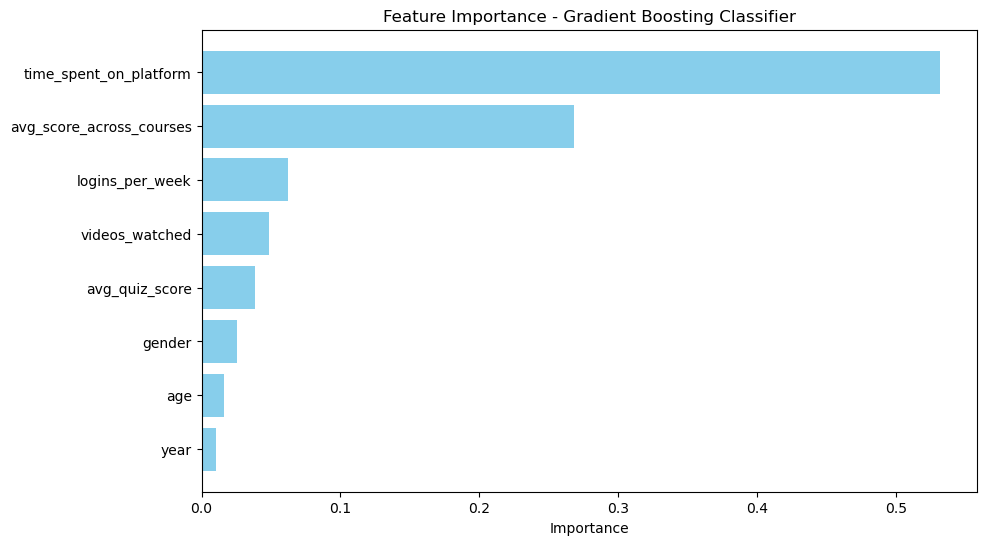

In [175]:
# Plot feature importance for models that support it
def plot_feature_importance(model, feature_names, model_name):
    """ Plot feature importances for a given model. """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = model.coef_[0]
    else:
        raise ValueError(f"Model {model_name} does not support feature importances.")
    
    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {model_name}')
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.show()

# Call feature importance for the best model
best_model = models[best_model_name]
plot_feature_importance(best_model, X_train.columns, best_model_name)


# Insights from Predictive Model

Most Important Features:


time_spent_on_platform: More time spent on the platform is generally associated with higher engagement and thus a greater likelihood of course completion.

avg_score_across_courses: This feature also plays a significant role. It suggests that students' overall academic performance across courses influences their likelihood of course completion.

-----------------------------------------------------------------------------------------------------------------------------
Moderately Important Features:

logins_per_week:This feature likely reflects student engagement with the platform, with more frequent logins indicating higher chances of course completion.<br>

avg_quiz_score: This indicates that the average quiz score correlates with whether a student completes a course or drops out. Students with higher quiz scores are more likely to complete the course.<br>

videos_watched: The number of videos watched is also a moderate-impact feature, suggesting that merely watching videos may predict completion.<br>

-----------------------------------------------------------------------------------------------------------------------------
Less Important Features:


gender: This feature has minimal importance, indicating that gender has little impact on predicting course completion in this dataset.<br>


year and age: These two features have almost no contribution in the model, implying that a student’s academic year and age do not significantly affect course completion.<br>

-----------------------------------------------------------------------------------------------------------------------------




---

### **Recommendations to Minimize Risk of Dropout:**

---

#### **Focus on Improving Platform Engagement:**
- **Time Spent on Platform**: Since time spent on the platform is a critical factor for course completion, encouraging students to spend more time learning can significantly improve retention rates. Consider implementing:
  - **Learning Streaks**: Offer rewards for students who log consistent hours on the platform.
  - **Engagement Reminders**: Automated reminders nudging students to revisit the platform.
  - **Live Study Sessions**: Organize live sessions to further enhance student interaction.

---

#### **Enhance Overall Academic Performance:**
- **Avg Score Across Courses**: Overall performance across all courses plays a major role. It’s important to:
  - **Offer Personalized Learning Plans**: Students can benefit from tailored learning plans based on their performance.
  - **Peer Study Groups**: Organize virtual study groups to foster collaborative learning.
  - **Academic Support**: Provide academic support services for students who are struggling across multiple courses.

---

#### **Improve Quiz Performance:**
- **Avg Quiz Score**: Quiz performance moderately impacts course completion. To address this:
  - **Feedback and Reinforcement**: Provide immediate and constructive feedback after quizzes to help students understand their mistakes.
  - **Adaptive Quiz Design**: Offer adaptive quizzes that adjust difficulty levels based on a student's performance.
  - **Extra Practice Resources**: Provide additional quizzes, flashcards, and mock tests to boost their performance.

---

#### **Boost Logins and Engagement:**
- **Logins per Week**: Regular logins are a sign of active engagement. Increasing login frequency can help students stay on track. Some strategies include:
  - **Gamification**: Implementing badges, leaderboards, and achievements to encourage frequent logins.
  - **Personalized Notifications**: Send personalized messages or alerts to remind students to log in based on their activity level.
  - **Weekly Challenges**: Introduce weekly learning challenges that require consistent logins to complete.

---

#### **Encourage Active Video Learning:**
- **Videos Watched**: While watching more videos correlates with higher completion rates, it is important to ensure students actively engage with the material. Recommendations:
  - **Interactive Videos**: Include quizzes and discussion prompts within videos to engage students more deeply.
  - **Content Recommendations**: Suggest videos based on their learning progress and areas of weakness.
  - **Completion Tracking**: Track video completion and suggest related videos or learning materials based on their watching habits.

---

#### **Address Additional Factors:**
- **Monitor Low-Risk Indicators (Gender, Year, Age)**: Although these features show minimal importance, it is still beneficial to:
  - **Track Progress**: Even if gender, year, and age have minimal influence, monitor students’ overall progress across various demographics to ensure no group is overlooked.

---

# Conclusion

This study demonstrates that synthetic data generated by CTGAN can be effectively used to mimic real data for predictive modeling in online education platforms. The correlation analysis and hypothesis tests confirmed that the synthetic data closely mimicked the original data, preserving key relationships between variables.

The clustering analysis provided actionable insights into the characteristics of at-risk students, revealing groups with low engagement and performance. Strategies such as personalized engagement and enhanced learning resources can significantly improve retention rates.

Additionally, the predictive modeling results highlighted the importance of specific features, such as average quiz scores and login frequency, in determining student success. The Gradient Boosting Classifier emerged as a particularly effective model, achieving highest performance.

By leveraging both clustering insights and predictive modeling, educational platforms can implement data-driven strategies to enhance learning outcomes and support student success.